In [2]:
import numpy as np
import pandas as pd
import re
import string

from textblob import TextBlob
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
df = pd.read_csv("C:/Users/Mahesh/Downloads/SMS Dataset/spam.csv", encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.rename(columns={'v1': 'class', 'v2': 'sms'}, inplace=True)

In [7]:
df.head()

,class,sms,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
threshold = 0.9 
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage >= threshold].index
df = df.drop(columns=columns_to_drop)

In [9]:
print("Remaining columns:", df.columns)

df = df.drop_duplicates()

df.head()

Remaining columns: Index(['class', 'sms'], dtype='object')


,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


C:\Users\Mahesh\AppData\Local\Temp\ipykernel_8812\789833794.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette="viridis")


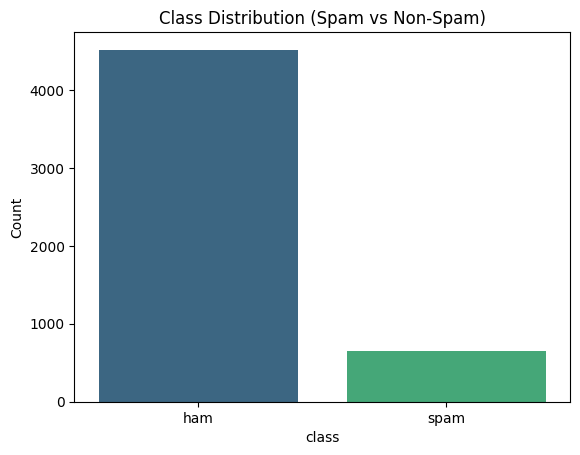

In [10]:
sns.countplot(x='class', data=df, palette="viridis")
plt.title("Class Distribution (Spam vs Non-Spam)")
plt.xlabel("class")
plt.ylabel("Count")
plt.show()

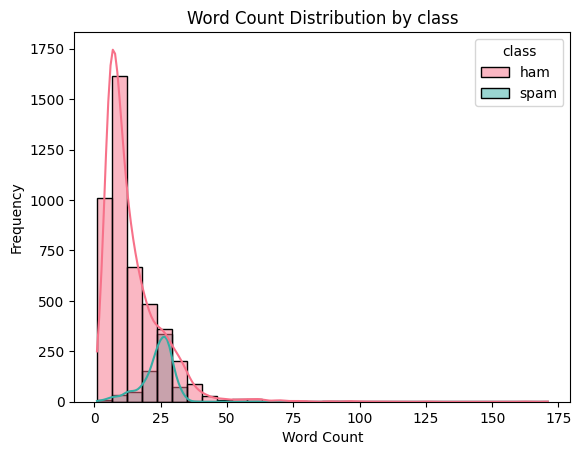

In [11]:
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='class', bins=30, kde=True, palette="husl")
plt.title("Word Count Distribution by class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

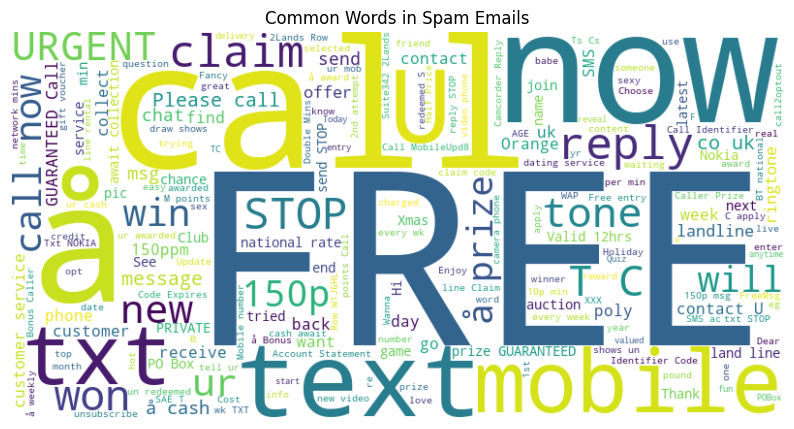

In [12]:
spam_text = df[df['class'] == 'spam']['sms'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Emails")
plt.show()

In [13]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class']) 

tfidf = TfidfVectorizer(max_features=5000)  

X = tfidf.fit_transform(df['sms']).toarray()
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

class SpamClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

model = SpamClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

model.eval()
y_pred_nn = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred_nn.extend(preds.tolist())

nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy: {nn_accuracy}")

Epoch 1, Loss: 0.3017560054619725
Epoch 2, Loss: 0.04770446226197796
Epoch 3, Loss: 0.010704871741248867
Epoch 4, Loss: 0.003846842580074176
Epoch 5, Loss: 0.0019678793702321575
Accuracy: 0.9816247582205029
